# IA de prédiction de l'impact environnemental
Cette IA à pour but de prédir l'impact sur le changement climatique (CO2 équivalent) d'un produit alimentaire.


# Exemple de base

## Import

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Prétraitement
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Évaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

## Data d'entraînement
Les données pour entraîner le modèle proviennent de l'ADEME et sont disponibles [à cette adresse](https://www.data.gouv.fr/datasets/agribalyse-3-1-synthese/).

In [2]:
df = pd.read_csv("agribalyse_data.csv", sep=",")
# Aperçu
df.head()

,Code AGB,Code CIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison,code avion,Livraison,Approche emballage,...,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux,Changement climatique - émissions biogéniques,Changement climatique - émissions fossiles,Changement climatique - émissions liées au changement d'affectation des sols
0,11172,11172.0,aides culinaires et ingrédients divers,aides culinaires,"Court-bouillon pour poissons, déshydraté","Aromatic stock cube, for fish, dehydrated",2.0,0.0,Ambiant (long),PACK PROXY,...,0.02680,0.1370,70.2,106.0,3.380,700.0,0.000051,0.1040,7.460,0.02120
1,25525,25525.0,aides culinaires et ingrédients divers,aides culinaires,"Pizza, sauce garniture pour",Topping sauce for pizza,2.0,0.0,Ambiant (long),PACK PROXY,...,0.00416,0.0303,11.0,67.7,2.470,24.4,0.000006,0.0336,1.020,-0.10800
2,11214,11214.0,aides culinaires et ingrédients divers,aides culinaires,"Préparation culinaire à base de soja, type ""cr...","Soy ""cream"" preparation",2.0,0.0,Ambiant (long),PACK PROXY,...,0.00723,0.0244,30.8,116.0,0.422,22.4,0.000004,0.0252,0.965,0.18400
3,11084,11084.0,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2.0,0.0,Ambiant (long),PACK PROXY,...,0.01500,0.1440,57.9,26.7,4.830,396.0,0.000079,0.0401,11.700,0.00655
4,20995,20995.0,aides culinaires et ingrédients divers,algues,"Ao-nori (Enteromorpha sp.), séchée ou déshydratée","Sea lettuce (Enteromorpha sp.), dried or dehyd...",2.0,0.0,Ambiant (long),PACK PROXY,...,0.01500,0.1440,57.9,26.7,4.830,396.0,0.000079,0.0401,11.700,0.00655


## Train Set
En machine learning, on divise les données en deux parties principales :
-Train Set (jeu d'entraînement)
-Test Set (jeu de test)

Cette séparation est essentielle pour évaluer la performance réelle du modèle.
Le Train Set est utilisé pour entraîner le modèle, c’est-à-dire lui faire apprendre les relations entre les variables d’entrée et la variable cible.
Le Test Set, lui, n’est jamais montré au modèle pendant l’entraînement. Il sert à simuler de nouvelles données jamais vues, comme dans un cas réel d’utilisation.
Cela permet de vérifier si le modèle généralise bien, c’est-à-dire s’il est capable de faire de bonnes prédictions sur des données inconnues et pas juste de “mémoriser” l’entraînement.

In [3]:
main_target = 'Changement climatique'

def setup(target):
    #Définir la variable cible
    y = df[target]

    #Supprimer la cible de X
    X = df.drop(target, axis=1)

    # Garder uniquement les lignes sans NaN dans y
    mask = y.notna()
    y = y.loc[mask]
    X = df.loc[mask].drop(target, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = setup(main_target)

## Pipeline de transformation
Les données non numériques ne peuvent pas être traitées directement par notre modèle, il faut donc les transformer. Plusieurs solutions existent, comme l'encodage par label (non adapté aux modèles linéaires) ou l'encodage one-hot, qui est préférable ici.
Il faut également décider comment gérer les données manquantes : supprimer les lignes concernées ou les remplacer par une valeur par défaut.

In [4]:
# Sélecteurs automatiques
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Pipelines
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),  # remplace NaN par moyenne
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),  # remplace NaN par 'unknown'
    OneHotEncoder(handle_unknown="ignore")
)

# Préprocesseur complet
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features),
    (categorical_pipeline, categorical_features)
)

def regressor(model_type):
    model = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model_type)
    ])
    return model

## Fonction d'évaluation
Pour juger un modèle de régression, on utilise plusieurs tests et visualisations qui permettent d’évaluer à la fois son apprentissage et sa capacité à prédire correctement.

La courbe d’apprentissage sert à observer comment la performance du modèle évolue lorsque la quantité de données d’entraînement augmente. Elle montre typiquement deux courbes : la performance sur les données utilisées pour entraîner le modèle, et la performance sur des données de validation. Cela permet de détecter si le modèle souffre de sous-apprentissage (les deux courbes sont basses) ou de sur-apprentissage (écart important entre les deux courbes). Un bon modèle est celui où les courbes convergent vers un niveau élevé, indiquant que le modèle généralise bien.

Les métriques comme l’erreur quadratique moyenne (MSE) ou l’erreur absolue moyenne (MAE) quantifient l’écart moyen entre les prédictions du modèle et les valeurs réelles sur un jeu de test indépendant. Elles permettent d’avoir une mesure précise de la qualité des prédictions. Le coefficient de détermination R2 donne également une idée de la proportion de variance expliquée par le modèle, donc de sa pertinence.
-La MSE calcule la moyenne des carrés des écarts. En élevant au carré chaque différence, elle pénalise fortement les erreurs importantes, ce qui rend cette métrique particulièrement sensible aux valeurs aberrantes. Cela signifie qu’une grosse erreur aura un impact beaucoup plus important sur la MSE, ce qui peut être utile si vous voulez que le modèle évite à tout prix les grosses erreurs.
-La MAE, quant à elle, calcule la moyenne des valeurs absolues des écarts, ce qui lui donne une interprétation plus intuitive : c’est l’écart moyen en valeur absolue entre les prédictions et les observations. Elle est moins sensible aux erreurs extrêmes car elle ne les amplifie pas par un carré, ce qui la rend plus robuste face aux valeurs aberrantes.
En résumé, la MSE met plus l’accent sur les grandes erreurs tandis que la MAE offre une mesure plus directe de l’erreur moyenne sans accentuation particulière. Le choix entre les deux dépend de ce que vous souhaitez privilégier dans votre modèle.

En combinant ces éléments, on peut vérifier que le modèle apprend correctement, qu’il n’est ni trop simple ni trop complexe, et qu’il fait des prédictions fiables. Ces tests doivent toujours être adaptés selon les objectifs et contraintes du projet.

In [5]:
def train_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Afficher des métriques adaptées à la régression
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 score:", r2_score(y_test, y_pred))

    # Learning curve (attention scoring doit être adapté)
    N, train_score, val_score = learning_curve(
        model, X_train, y_train,
        cv=4, scoring='r2', train_sizes=np.linspace(0.1, 1, 10)
    )
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

In [6]:
def result_evaluation(model):
    y_pred = model.predict(X_test)
    
    # 1. Valeurs réelles vs prédites
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(y_test.values, label='Valeurs réelles', marker='o')
    plt.plot(y_pred, label='Valeurs prédites', marker='x')
    plt.title("Valeurs réelles vs. prédites")
    plt.xlabel("Index")
    plt.ylabel("Changement climatique (kg CO₂)")
    plt.legend()

    # 2. Erreur absolue
    plt.subplot(1, 2, 2)
    errors = np.abs(y_test.values - y_pred)
    plt.plot(errors, color='red', marker='.', label="Erreur absolue")
    plt.title("Erreur de prédiction")
    plt.xlabel("Index")
    plt.ylabel("Erreur absolue (kg CO₂)")
    plt.legend()

    plt.tight_layout()
    plt.show()

MSE: 0.004375897683299186
MAE: 0.03361960503444749
R2 score: 0.9999466064190032


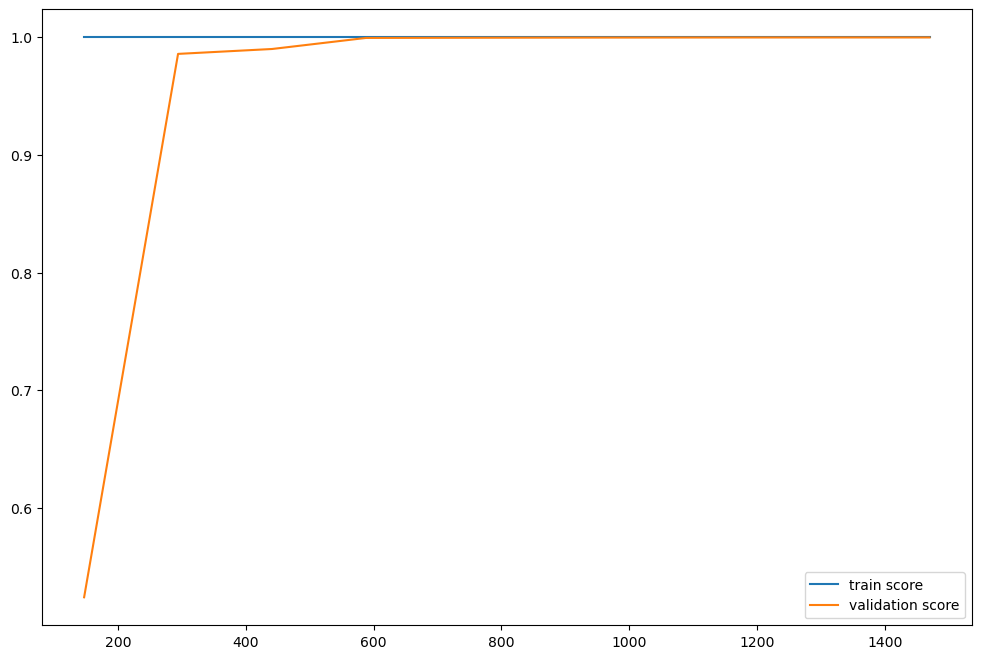

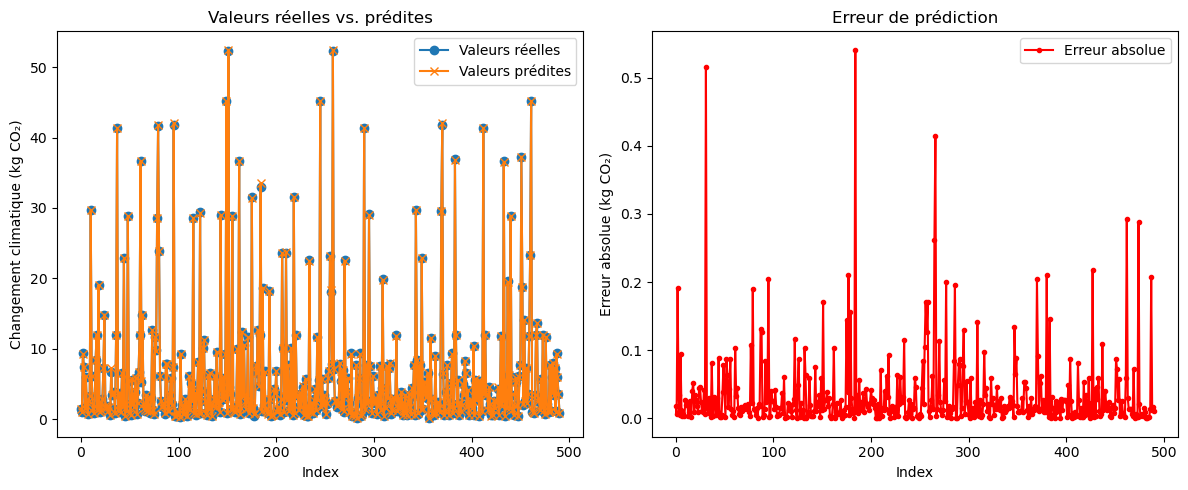

In [7]:
model = regressor(LinearRegression())
train_evaluation(model)
result_evaluation(model)

## Corrélation
La corrélation est une mesure statistique qui indique dans quelle mesure deux variables sont liées entre elles. Elle varie entre :
+1 : corrélation positive parfaite → quand une variable augmente, l'autre aussi.
0 : aucune corrélation → les deux variables n'ont pas de lien linéaire direct.
-1 : corrélation négative parfaite → quand une variable augmente, l'autre diminue.

In [8]:
def cor_eval(display=True):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_corr = df[numerical_cols].corr(method='pearson')[main_target].drop(main_target)

    if display:
        print("Corrélations Pearson avec " + main_target + " :\n")
        print(num_corr.sort_values(ascending=False))
        return

    return num_corr.to_dict()

cor_eval()

Corrélations Pearson avec Changement climatique :

Score unique EF                                                                 0.953969
Eutrophisation terrestre                                                        0.935170
Acidification terrestre et eaux douces                                          0.930355
Particules fines                                                                0.925290
Changement climatique - émissions biogéniques                                   0.906216
Effets toxicologiques sur la santé humaine : substances cancérogènes            0.893707
Utilisation du sol                                                              0.865662
Effets toxicologiques sur la santé humaine : substances non-cancérogènes        0.828495
Changement climatique - émissions fossiles                                      0.800442
Écotoxicité pour écosystèmes aquatiques d'eau douce                             0.667394
Eutrophisation marine                                      

## Feature Engineering
Après avoir examiné les corrélations entre les différentes variables et notre variable cible, nous sommes en mesure d’identifier celles qui ont un impact significatif sur le modèle. En conservant les variables les plus pertinentes et en supprimant celles qui présentent une corrélation faible ou négligeable, nous améliorons la qualité des données utilisées. Ce travail de sélection, de transformation ou de création de nouvelles variables à partir des données existantes s’appelle le Feature Engineering.

In [9]:
def drop_columns(threshold, upper=False):
    # Récupérer toutes les corrélations/scores (num + catégoriel)
    scores = cor_eval(display=False)

    if upper:
        # Supprimer colonnes avec score >= threshold
        cols_to_drop = [col for col, score in scores.items() if score >= threshold]
    else:
        # Supprimer colonnes avec score < threshold
        cols_to_drop = [col for col, score in scores.items() if score < threshold]

    dfClean = df.drop(columns=cols_to_drop, errors='ignore')

    print(f"Colonnes supprimées ({'>= ' if upper else '< '} {threshold}): {cols_to_drop}")

    return dfClean

df = drop_columns(0.10)  # supprime colonnes avec score < 0.20

Colonnes supprimées (<  0.1): ['Code CIQUAL', 'code saison', 'code avion', "Appauvrissement de la couche d'ozone", 'Épuisement des ressources eau']


In [10]:
X_train, X_test, y_train, y_test = setup(main_target)

MSE: 0.008549662476827296
MAE: 0.036420776677006626
R2 score: 0.9998956792116749


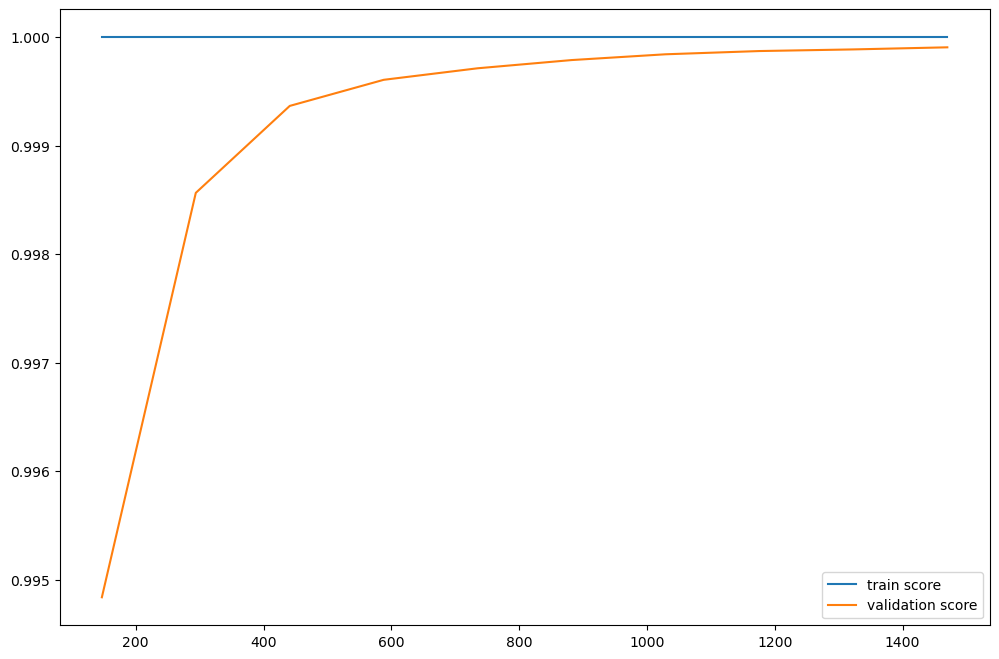

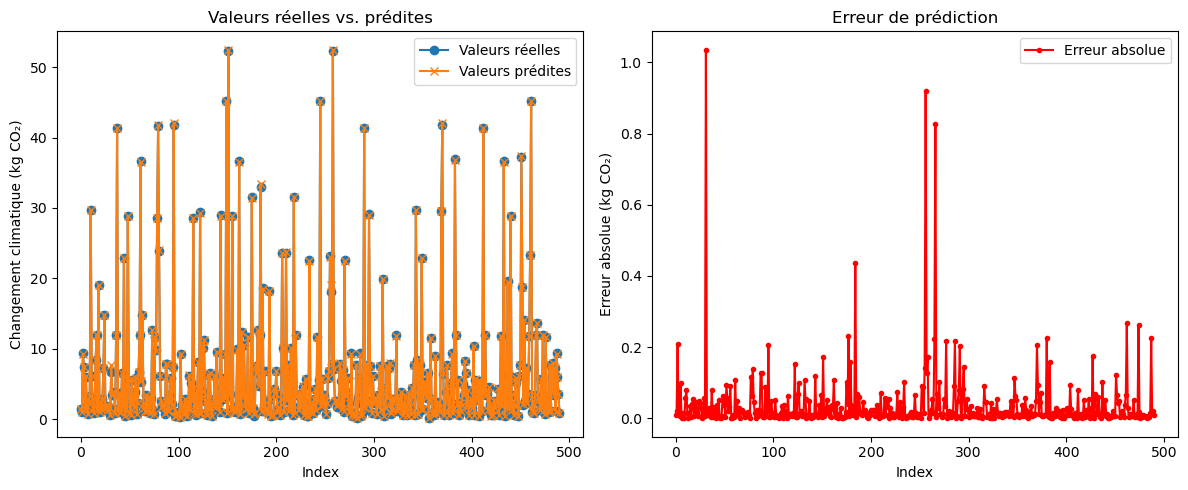

In [11]:
model = regressor(LinearRegression())
train_evaluation(model)
result_evaluation(model)

On constate qu’après la suppression de certaines variables peu corrélées à la cible, le modèle parvient tout de même à prédire avec une grande précision le niveau de changement climatique. Cela montre que toutes les variables initiales ne sont pas nécessaires à la performance du modèle. Le choix des caractéristiques à conserver ou à éliminer dépendra donc fortement de vos objectifs métier et des contraintes définies dans votre cahier des charges (ex. : interprétabilité, temps de calcul, simplicité du modèle, etc.).

# Cas plus compliqué

Dans notre cas précédent, la forte corrélation entre le score EF et le changement climatique a permis d’obtenir très rapidement des résultats satisfaisants lors des premiers tests. Ici, nous allons modifier un peu nos données en supprimant les variables trop corrélées afin de relever un peu le défi. Cela nous permettra d’optimiser les variables restantes et de tester différents modèles pour identifier celui qui est le plus performant.

In [14]:
df = pd.read_csv("agribalyse_data.csv", sep=",")
cor_eval()

Corrélations Pearson avec Changement climatique :

Score unique EF                                                                 0.953969
Eutrophisation terrestre                                                        0.935170
Acidification terrestre et eaux douces                                          0.930355
Particules fines                                                                0.925290
Changement climatique - émissions biogéniques                                   0.906216
Effets toxicologiques sur la santé humaine : substances cancérogènes            0.893707
Utilisation du sol                                                              0.865662
Effets toxicologiques sur la santé humaine : substances non-cancérogènes        0.828495
Changement climatique - émissions fossiles                                      0.800442
Écotoxicité pour écosystèmes aquatiques d'eau douce                             0.667394
Eutrophisation marine                                      

In [17]:
max_threshold = 70 #en %
df = drop_columns(max_threshold / 100, True) #Supprimons toutes les corrélations supérieures au seuil

Colonnes supprimées (>=  0.7): ['Score unique EF', 'Particules fines', 'Effets toxicologiques sur la santé humaine\xa0: substances non-cancérogènes', 'Effets toxicologiques sur la santé humaine\xa0: substances cancérogènes', 'Acidification terrestre et eaux douces', 'Eutrophisation terrestre', 'Utilisation du sol', 'Changement climatique - émissions biogéniques', 'Changement climatique - émissions fossiles']


In [15]:
X_train, X_test, y_train, y_test = setup(main_target)

In [16]:
X_train

,Code AGB,Code CIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison,code avion,Livraison,Approche emballage,...,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux,Changement climatique - émissions biogéniques,Changement climatique - émissions fossiles,Changement climatique - émissions liées au changement d'affectation des sols
996,20501,20501.0,"fruits, légumes, légumineuses et oléagineux",légumineuses,"Haricot blanc, sec","Haricot bean, dry",2.0,0.0,Ambiant (long),PACK AGB,...,0.00239,0.0221,12.10,77.4,0.972,11.30,0.000004,0.01470,0.432,0.00120
1363,16738,16738.0,matières grasses,margarines,Matière grasse végétale (type margarine) à 50-...,"Vegetable fat (margarine type), 50-63% fat, li...",2.0,0.0,Glacé,PACK AGB,...,0.01730,0.0668,46.50,125.0,1.730,28.40,0.000008,0.02540,1.520,1.62000
194,20253,20253.0,aliments infantiles,petits pots salés et plats infantiles,"Soupe pour bébé légumes, céréales et lait","Soup for baby, with vegetables, cereals and milk",2.0,0.0,Ambiant (long),PACK PROXY,...,0.00194,0.0108,6.54,13.7,0.425,24.10,0.000004,0.00947,0.844,0.00634
175,3000_2,3000.0,aliments infantiles,laits et boissons infantiles,"Lait 1er âge, poudre soluble (préparation pour...","Baby milk, first age, powder, rehydrated at co...",2.0,0.0,Ambiant (long),PACK PROXY,...,0.00391,0.0539,14.50,54.8,0.274,5.15,0.000002,0.54000,0.418,0.12900
1257,19641,19641.0,lait et produits laitiers,produits laitiers frais et assimilés,"Faisselle, 6% MG environ","Drained soft fresh cheese, around 6% fat",2.0,0.0,Glacé,PACK AGB,...,0.01770,0.2680,63.20,241.0,0.593,28.20,0.000015,2.87000,1.970,0.46100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,53503,53503.0,"fruits, légumes, légumineuses et oléagineux",pommes de terre et autres tubercules,"Igname, épluchée, bouillie/cuite à l'eau","Yam or Indian potato, peeled, boiled/cooked in...",2.0,0.0,Ambiant (moyen),PACK AGB,...,0.00362,0.0383,10.70,27.2,2.700,12.40,0.000004,0.02070,0.761,0.02380
1731,9341_1,9341.0,produits céréaliers,"pâtes, riz et céréales","Quinoa, cuit","Quinoa, boiled/cooked in water, unsalted",2.0,0.0,Ambiant (long),PACK AGB,...,0.00623,0.0546,59.30,69.0,13.600,25.80,0.000005,0.00610,0.921,1.80000
763,15049,15049.0,"fruits, légumes, légumineuses et oléagineux",fruits à coque et graines oléagineuses,Mélange apéritif de graines (non salées) et ra...,Mix of unsalted grains/nuts and raisins,2.0,0.0,Ambiant (long),PACK PROXY,...,0.02930,0.1830,89.80,380.0,20.700,23.90,0.000013,0.10100,2.340,0.17200
835,20221,20221.0,"fruits, légumes, légumineuses et oléagineux",légumes,"Chou chinois (pak-choi ou pé-tsai), cuit","Chinese cabbage (nappa cabbage or bok choy), c...",2.0,0.0,Ambiant (moyen),PACK AGB,...,0.00661,0.0293,9.68,45.3,0.347,24.20,0.000007,0.09680,1.500,0.00313
